In [1]:
# QUESTION N° 2:
# SHOULD THE DHPDNYC FOCUS ON ANY PARTICULAR SET OF BOROUGHS, ZIP CODES, OR STREET 
# (WHERE THE COMPLAINTS ARE SEVERE) FOR THE SPECIFIC TYPE OF COMPLAINTS YOU 
# IDENTIFIED IN RESPONSE TO QUESTION 1?

# According with the course “MACHINE LEARNING WITH PYTHON: A PRACTICAL INTRODUCTION”, the best option to clustering spatial datasets is “DBSCAN”. 

# To do that, it is necessary to define some parameters like “min_samples” and “eps”. However, there is not a standard procedure to define those ones, 
# it generally depends of the type of data analyzed. So, I´ll follow the next steps:

# 1. Take the “zip_code” areas as a referential metric to define the parameters “min_samples” and “eps” (Postal service keeps some analogy with
# NYC311 since both should be able to arrive to any place of the city as fast as they can. In the case of postal service, they have been using
# the zip code to manage their delivering job across the city since 1940´s, and today they still use this method, so, I think it will be a 
# good option to define my parameters).

# 2. Define “min_samples”: I´ll calculate the percentiles .01, .05, .25, .50, .75, .95 and .99 of the number of complaints per each “zip code”.

# 3. Define “eps”: I´ll calculate the percentiles .01, .05, .25, .50, .75, .95 and .99 of the expression "(zip_code area)^0.5)/2" which is equivalent, 
# approximately to the radius distance of each zip code area. 
# Notice that the “zip_code area” will be estimated as a function of the standardized “latitude” and “longitude” features 
#(area= (maxlat-minlat)*(maxlong-minlong))

# 4. Apply DBSCAN clustering over a random sample of 2018´s data set, using different combinations of the parameters (according with the percentiles
# computed per each one), and selecting the optimal combination (neither many nor few clusters)    

# In addition to the aforementioned, I Think this analysis shouldn´t consider old complaints, because, they are outdated, so they only add 
# noise to the analysis. For example, surently any 2010-2017s complaint which persist in 2018 would generate a new NYC311 request in 2018,
# then, it is sufficient to consider only 2018 complaints to recomend where the DHPDNYC should focus in the near future. 

# Finaly, to optimize DBSCAN proccess I´ll apply this technique over a random sample and extrapolate its results. 

#downloading raw data

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

client_cred = ibm_boto3.client(service_name='s3',
ibm_api_key_id=<**REPLACE_WITH_YOUR_IBM_API_KEY_ID**>,
ibm_auth_endpoint='https://iam.bluemix.net/oidc/token',
config=Config(signature_version='oauth'),
endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

bucket = <**REPLACE_WITH_YOUR_BUCKET_ID**>

client_cred.download_file(Bucket=bucket,Key='df_raw_cos.pkl',Filename='./df_raw_local.pkl')

DF = pd.read_pickle('./df_raw_local.pkl')

In [2]:
# 0. PRELIMINAR PREPROCESSING OVER RAW DATA 

# import pandas as pd
import numpy as np 
from sklearn.cluster import DBSCAN 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn.preprocessing import StandardScaler 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline


DF.describe(include="all")

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,closed_date,location_type,status
count,5792356,5.792356e+06,5792356,5.710463e+06,5738216,5738216,5713365,5710864,5792356,5.710489e+06,5.710489e+06,5674451,5738217,5792356
unique,1470844,NaN,22,NaN,175614,6731,1,89,6,NaN,NaN,669054,1,4
top,2013-01-24 00:00:00,NaN,HEAT/HOT WATER,NaN,34 ARDEN STREET,GRAND CONCOURSE,ADDRESS,BROOKLYN,BROOKLYN,NaN,NaN,2012-11-07 00:00:00,RESIDENTIAL BUILDING,Closed
freq,7581,NaN,1144601,NaN,14248,89146,5713365,1955808,1669117,NaN,NaN,7296,5738217,5667550
first,2010-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-12-31 00:00:00,NaN,NaN
last,2019-06-15 19:23:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-15 21:36:13,NaN,NaN
mean,NaN,2.897735e+07,NaN,1.074797e+04,NaN,NaN,NaN,NaN,NaN,4.075406e+01,-7.391986e+01,NaN,NaN,NaN
std,NaN,7.479520e+06,NaN,5.129045e+02,NaN,NaN,NaN,NaN,NaN,9.090343e-02,5.685212e-02,NaN,NaN,NaN
min,NaN,1.562973e+07,NaN,1.000100e+04,NaN,NaN,NaN,NaN,NaN,4.049934e+01,-7.425312e+01,NaN,NaN,NaN
25%,NaN,2.271058e+07,NaN,1.045200e+04,NaN,NaN,NaN,NaN,NaN,4.067107e+01,-7.395198e+01,NaN,NaN,NaN


In [3]:
# 0. PRELIMINAR PREPROCESSING OVER RAW DATA_CONTINUATION
DF.dtypes

created_date        datetime64[ns]
unique_key                   int64
complaint_type              object
incident_zip               float64
incident_address            object
street_name                 object
address_type                object
city                        object
borough                     object
latitude                   float64
longitude                  float64
closed_date         datetime64[ns]
location_type               object
status                      object
dtype: object

In [4]:
# 0.1. CREATING DATA SET FROM 01/01/2018 UNTIL 31/12/2018

DF2018=DF[DF["created_date"]>='2018-01-01']
DF2018=DF2018[DF2018["created_date"]<='2018-12-31']
DF2018=DF2018.sort_values(by="created_date",ascending=True)
DF2018.reset_index(drop=True,inplace=True)
DF2018.describe(include="all")

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,closed_date,location_type,status
count,608645,6.086450e+05,608645,596750.000000,604690,604690,597016,596862,608645,596750.000000,596750.000000,605404,604690,608645
unique,367418,NaN,15,NaN,53683,4532,1,47,6,NaN,NaN,169680,1,2
top,2018-01-24 00:18:31,NaN,HEAT/HOT WATER,NaN,89-21 ELMHURST AVENUE,GRAND CONCOURSE,ADDRESS,BROOKLYN,BROOKLYN,NaN,NaN,2018-10-24 18:56:33,RESIDENTIAL BUILDING,Closed
freq,18,NaN,223109,NaN,2556,8442,597016,198892,201403,NaN,NaN,293,604690,605404
first,2018-01-01 00:00:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 02:05:57,NaN,NaN
last,2018-12-30 23:56:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-14 21:57:59,NaN,NaN
mean,NaN,3.964232e+07,NaN,10737.124374,NaN,NaN,NaN,NaN,NaN,40.755057,-73.920861,NaN,NaN,NaN
std,NaN,1.076546e+06,NaN,512.213328,NaN,NaN,NaN,NaN,NaN,0.090481,0.056889,NaN,NaN,NaN
min,NaN,3.806530e+07,NaN,10001.000000,NaN,NaN,NaN,NaN,NaN,40.501360,-74.250592,NaN,NaN,NaN
25%,NaN,3.862956e+07,NaN,10452.000000,NaN,NaN,NaN,NaN,NaN,40.671329,-73.952699,NaN,NaN,NaN


In [5]:
# 0.2. STANDARIZATION OF COMPLAINT TYPE -HEATING- AND -HEAT/HOT WATER- AS -HEAT/HOT WATER-

DF2018["complaint_type"]=np.where(DF2018["complaint_type"]=="HEATING","HEAT/HOT WATER",DF2018["complaint_type"])
DF2018.describe(include="all")

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,closed_date,location_type,status
count,608645,6.086450e+05,608645,596750.000000,604690,604690,597016,596862,608645,596750.000000,596750.000000,605404,604690,608645
unique,367418,NaN,15,NaN,53683,4532,1,47,6,NaN,NaN,169680,1,2
top,2018-01-24 00:18:31,NaN,HEAT/HOT WATER,NaN,89-21 ELMHURST AVENUE,GRAND CONCOURSE,ADDRESS,BROOKLYN,BROOKLYN,NaN,NaN,2018-10-24 18:56:33,RESIDENTIAL BUILDING,Closed
freq,18,NaN,223109,NaN,2556,8442,597016,198892,201403,NaN,NaN,293,604690,605404
first,2018-01-01 00:00:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 02:05:57,NaN,NaN
last,2018-12-30 23:56:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-14 21:57:59,NaN,NaN
mean,NaN,3.964232e+07,NaN,10737.124374,NaN,NaN,NaN,NaN,NaN,40.755057,-73.920861,NaN,NaN,NaN
std,NaN,1.076546e+06,NaN,512.213328,NaN,NaN,NaN,NaN,NaN,0.090481,0.056889,NaN,NaN,NaN
min,NaN,3.806530e+07,NaN,10001.000000,NaN,NaN,NaN,NaN,NaN,40.501360,-74.250592,NaN,NaN,NaN
25%,NaN,3.862956e+07,NaN,10452.000000,NaN,NaN,NaN,NaN,NaN,40.671329,-73.952699,NaN,NaN,NaN


In [6]:
# 0.3. CREATING DATAFRAME -DFQ2-, BUT ONLY WITH THE -HEAT/HOT WATER- ROWS

# in this dataframe, the -latitude and longitude- columns contains null values, but it is les than 1% of the total rows
# therefore the preproccessing method to apply will be to delete those rows
# in this dataframe, the -incident_zip- column format will be changed from -float64- to -object-, since it is a categorical variable

DF2018HW=DF2018[DF2018["complaint_type"]=="HEAT/HOT WATER"]
a_1=DF2018HW.shape[0]     
DF2018HW2=DF2018HW.dropna(subset=["latitude"],axis=0,inplace=False)
DF2018HW3=DF2018HW2.dropna(subset=["longitude"],axis=0,inplace=False)
DF2018HW4=DF2018HW3.dropna(subset=["street_name"],axis=0,inplace=False)
DF2018HW=DF2018HW4
a_2=DF2018HW.shape[0]
DF2018HW["incident_zip"]=DF2018HW["incident_zip"].astype(object)
DF2018HW.reset_index(drop=True,inplace=True)
print("total null rows deleted: ",a_1-a_2," of ",a_1," rows")
DFQ2=DF2018HW
DFQ2.shape

total null rows deleted:  6836  of  223109  rows


(216273, 14)

In [7]:
# 0.4 Preliminar exploratory analysis over DATAFRAME -DFQ2- 1

#DFQ2.head()
DFQ2.describe(include="all")

# Complaints are distributed among 6 "boroughs", 183 "incident_zip", 3835 "street names" and 35693 "incident address"
# Respect of "incident_zip", "street names" and "incident address", each of them includes small portions of complaints  
# The top "incident_zip" includes only 7283 complaints (3,4%) of total complaints
# The top "street name" includes only 3712 complaints (1,7%) of total complaints
# The top "incident_address" includes only 2478 complaints (1,1%) of total complaints
# Then perhaps those features have too many categories, with very few complaints each as to make some recommendation to the DHPDNYC
# Lets see what hapens with boroughs

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,closed_date,location_type,status
count,216273,2.162730e+05,216273,216273.0,216273,216273,216273,216273,216273,216273.000000,216273.000000,215423,216273,216273
unique,209606,NaN,1,183.0,35693,3835,1,47,6,NaN,NaN,51611,1,2
top,2018-03-31 13:53:28,NaN,HEAT/HOT WATER,11226.0,89-21 ELMHURST AVENUE,GRAND CONCOURSE,ADDRESS,BRONX,BRONX,NaN,NaN,2018-10-24 18:56:33,RESIDENTIAL BUILDING,Closed
freq,10,NaN,216273,7283.0,2478,3712,216273,69372,69372,NaN,NaN,293,216273,215423
first,2018-01-01 00:00:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 02:05:57,NaN,NaN
last,2018-12-30 23:56:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-30 16:41:20,NaN,NaN
mean,NaN,3.949100e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.759000,-73.920652,NaN,NaN,NaN
std,NaN,1.218783e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089507,0.054277,NaN,NaN,NaN
min,NaN,3.806665e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.506633,-74.249923,NaN,NaN,NaN
25%,NaN,3.834055e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.674551,-73.953027,NaN,NaN,NaN


In [8]:
DF_borough=DFQ2[['borough', 'unique_key']].groupby(["borough"],as_index=False).count().sort_values(by="borough",ascending=True)
DF_borough['part%']=100*(DF_borough.unique_key/DF_borough.unique_key.sum())
DF_borough

# The 63,46% of HEAT/HOT WATER complaints are in the boroughs "BRONX (32.07%)" and "BROOKLYN (31.39%)"
# but perhaps those boroughs are too large. So recommending DHPDNYC to focus on them would be too general.
# It suggests the needing of refine the analysis 
# Lets see how it looks over a NYC map

# DFQ2[DFQ2["borough"]=='Unspecified'] it isn´t a null row


,borough,unique_key,part%
0,BRONX,69372,32.076126
1,BROOKLYN,67888,31.389956
2,MANHATTAN,47911,22.153020
3,QUEENS,28879,13.353031
4,STATEN ISLAND,2222,1.027405
5,Unspecified,1,0.000462


In [9]:
# 1. PRELIMINAR GEO VISUALIZATION OF A DATA SET RANDOM SAMPLE
# 1.1. RANDOM SAMPLE (it would be unnecessary include all the complaints in the map)

sample00=DFQ2.sample(n=2000,random_state=2)
print(sample00.shape)
sample00.head()

(2000, 14)


,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,closed_date,location_type,status
156968,2018-10-29 05:02:54,40693615,HEAT/HOT WATER,10029,2026 2 AVENUE,2 AVENUE,ADDRESS,NEW YORK,MANHATTAN,40.789431,-73.943295,2018-10-30 02:12:52,RESIDENTIAL BUILDING,Closed
215862,2018-12-30 12:38:20,41314378,HEAT/HOT WATER,10461,1404 EDWARDS AVENUE,EDWARDS AVENUE,ADDRESS,BRONX,BRONX,40.838430,-73.836739,2018-12-31 20:09:59,RESIDENTIAL BUILDING,Closed
35748,2018-01-11 12:20:27,38191874,HEAT/HOT WATER,11206,48 JEFFERSON STREET,JEFFERSON STREET,ADDRESS,BROOKLYN,BROOKLYN,40.698646,-73.933228,2018-01-15 09:48:20,RESIDENTIAL BUILDING,Closed
149297,2018-10-22 18:27:19,40620002,HEAT/HOT WATER,10024,328 WEST 89 STREET,WEST 89 STREET,ADDRESS,NEW YORK,MANHATTAN,40.791136,-73.977234,2018-10-26 19:41:01,RESIDENTIAL BUILDING,Closed
124532,2018-07-02 06:51:29,39621071,HEAT/HOT WATER,11207,595 SUTTER AVENUE,SUTTER AVENUE,ADDRESS,BROOKLYN,BROOKLYN,40.669137,-73.896853,2018-07-15 11:38:52,RESIDENTIAL BUILDING,Closed


In [10]:
# GEO VISUALIZATION
# installing folium

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/DSX-Python35

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2018.8.24          |        py35_1001         139 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    openssl-1.0.2r             |       h14c3975_0         3.1 MB  conda-forge
    altair-2.2.2               |           py35_1         462 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         4.0 MB

The following NEW packages will

In [11]:
# define the map centered around NYC with a low zoom level

nyc_map = folium.Map(location=[40.76758, -73.92298], zoom_start=11)

# display NYC map
nyc_map




In [12]:
# instantiate a feature group for the NYC311 incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through a random sample of 100 NYC311 requirements and add each to the incidents feature group

for lat, lng, in zip(sample00.latitude, sample00.longitude):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=.1, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

# add incidents to map
nyc_map.add_child(incidents)

nyc_map


In [13]:
# 4. CLUSTERING BY DBSCAN

# The Preliminar map suggest than exist a slightly higher density of complaints 
# in the south of the Bronx, the north of Manhattan and in the center-south of Brooklin
# DBSCAN will by applied over a bigger random sample (I tried to apply it over the 2018 full data set (DFQ2), but the Watson kernel died always)
# Notice that the number of complaints within the sample maintains similar proportions as the full data in top categories

sample01=DFQ2.sample(n=20000,random_state=3)
print(sample01.shape)
sample01.describe(include="all")

(20000, 14)


,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,closed_date,location_type,status
count,20000,2.000000e+04,20000,20000.0,20000,20000,20000,20000,20000,20000.000000,20000.000000,19932,20000,20000
unique,19930,NaN,1,174.0,9985,2358,1,44,5,NaN,NaN,14093,1,2
top,2018-10-31 18:51:33,NaN,HEAT/HOT WATER,11226.0,89-21 ELMHURST AVENUE,GRAND CONCOURSE,ADDRESS,BRONX,BRONX,NaN,NaN,2018-05-18 10:13:06,RESIDENTIAL BUILDING,Closed
freq,3,NaN,20000,705.0,234,347,20000,6350,6350,NaN,NaN,20,20000,19932
first,2018-01-01 00:06:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 10:38:12,NaN,NaN
last,2018-12-30 23:35:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-26 12:57:43,NaN,NaN
mean,NaN,3.949466e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.758517,-73.921449,NaN,NaN,NaN
std,NaN,1.219516e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.089188,0.054270,NaN,NaN,NaN
min,NaN,3.807207e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.510277,-74.249022,NaN,NaN,NaN
25%,NaN,3.834061e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.674578,-73.954092,NaN,NaN,NaN


In [14]:
# Computing the number of complaints per each zip code from my sample

Z100=sample01[["incident_zip","unique_key"]]
Z100.head()
Z101=Z100.groupby(["incident_zip"]).count()
Z101.head()

,unique_key
incident_zip,
10001.0,33
10002.0,186
10003.0,83
10006.0,12
10007.0,2


In [15]:
# Computing percentiles of the number of complaints per zip code 

mean = Z101["unique_key"].mean()
p01 = Z101["unique_key"].quantile(.01)
p05 = Z101["unique_key"].quantile(.05)
p25 = Z101["unique_key"].quantile(.25)
p50 = Z101["unique_key"].quantile(.50)
p75 = Z101["unique_key"].quantile(.75)
p95 = Z101["unique_key"].quantile(.95)
p99 = Z101["unique_key"].quantile(.99)
max = Z101["unique_key"].max()
print("""
    mean: %d
    p01: %d
    p05: %d
    p25: %d
    p50: %d
    p75: %d
    p95: %d
    p99: %d
    max: %d
""" % (mean,p01, p05, p25, p50, p75, p95, p99,max))


    mean: 114
    p01: 1
    p05: 3
    p25: 20
    p50: 62
    p75: 157
    p95: 429
    p99: 556
    max: 705



In [16]:
# 4.2. DEFINE ‘eps’ PARAMETER:
# 4.2.1. STANDARDIZING LATITUDE AND LONGITUDE 

from sklearn.preprocessing import StandardScaler

Z04 = sample01[['latitude','longitude']]
Z04 = np.nan_to_num(Z04)
Z04 = StandardScaler().fit_transform(Z04)
Z04=pd.DataFrame(Z04)
headers=['lat_st','long_st']
Z04.columns=headers
Z04['zip']=DFQ2.incident_zip
Z04.head()



,lat_st,long_st,zip
0,-1.342317,-0.438585,10468
1,1.109042,0.490856,10452
2,-0.236955,-1.147439,10032
3,0.326587,-0.947050,11213
4,-0.915584,-0.515536,10463


In [17]:
# 4.2.2. COMPUTING ZIP CODE AREAS SINCE LATITUDE AND LONGITUDE COORDS

Z05=Z04.groupby(['zip']).min()                          # minimum lat and long coord per each zip code
headers=['minlat_st', 'minlong_st']
Z05.columns=headers

Z06=Z04.groupby(['zip']).max()       # maximum lat and long coord per each zip code

Z05['maxlat_st']=Z06['lat_st']
Z05['maxlong_st']=Z06['long_st']

Z05['dist_lat']=Z05.maxlat_st-Z05.minlat_st   # Estimating lat distances per each zip code
Z05['dist_long']=Z05.maxlong_st-Z05.minlong_st  # Estimating long distances per each zip code
Z05['area']=Z05.dist_lat*Z05.dist_long   # Estimating areas per each zip code
Z05['diameter']=Z05.area**.5   # Estimating the radius of each zip code
Z05['radius']=Z05.diameter/2

#Z05.head()


In [18]:
# Computing percentiles of the eps according with the mean radiud distance per each zip code 

eps_mean = Z05["radius"].mean()
eps_p01 = Z05["radius"].quantile(.01)
eps_p05 = Z05["radius"].quantile(.05)
eps_p25 = Z05["radius"].quantile(.25)
eps_p50 = Z05["radius"].quantile(.50)
eps_p75 = Z05["radius"].quantile(.75)
eps_p95 = Z05["radius"].quantile(.95)
eps_p99 = Z05["radius"].quantile(.99)
eps_max = Z05["radius"].max()
print("""
    eps_mean: %.4f
    eps_p01: %.4f
    eps_p05: %.4f
    eps_p25: %.4f
    eps_p50: %.4f
    eps_p75: %.4f
    eps_p95: %.4f
    eps_p99: %.4f
    eps_max: %.4f
""" % (eps_mean,eps_p01, eps_p05, eps_p25, eps_p50, eps_p75, eps_p95, eps_p99,max))


    eps_mean: 1.9808
    eps_p01: 0.0000
    eps_p05: 0.2192
    eps_p25: 1.6556
    eps_p50: 2.1016
    eps_p75: 2.5131
    eps_p95: 2.7744
    eps_p99: 3.1796
    eps_max: 705.0000



In [19]:
# 4.3. DBSCAN CLUSTERING

# from sklearn.cluster import DBSCAN
import sklearn.utils
# from sklearn.preprocessing import StandardScaler

sklearn.utils.check_random_state(1000)
Clus_dataSet = Z04[['lat_st','long_st']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN

db = DBSCAN(eps=eps_p05, min_samples=p99).fit(Clus_dataSet) # after trying with diferent parameter combinations I found "eps_p05" and "p99" as the best 
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
sample01["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 

# A sample of clusters
sample01.shape                   

(20000, 15)

In [20]:
set(sample01["Clus_Db"]) # DBSCAN shows 3 clusters and outliers

{-1, 0, 1, 2}

In [21]:
# 4.4.2. GEO VISUALIZATION WITH FOLIUM

# 4.4.2.0. SAMPLE TO SHOW IN THE MAP

sample02=sample01.sample(n=400,random_state=4)
#print(sample02.shape)
#sample02.head()

s_out=sample02[sample02["Clus_Db"]==-1]
s_c00=sample02[sample02["Clus_Db"]==0]
s_c01=sample02[sample02["Clus_Db"]==1]
s_c02=sample02[sample02["Clus_Db"]==2]
# s_c03=sample02[sample02["Clus_Db"]==3]

print(s_out.shape[0],s_c00.shape[0],s_c01.shape[0],s_c02.shape[0])   #,s_c03.shape[0])




134 174 77 15


In [22]:
# 4.4.2.1. EMPTY MAP

# define the map centered around NYC with a low zoom level

nyc_map_02 = folium.Map(location=[40.76758, -73.92298], zoom_start=11)

# display NYC map
# nyc_map_02



In [25]:
# 4.4.2.2. CLUSTERS ADD
# instantiate various feature group for the clusters in the dataframe

rad=.3

outliers = folium.FeatureGroup(name='outlier')
clus_00 = folium.FeatureGroup(name='Cluster_0')
clus_01 = folium.FeatureGroup(name='Cluster_1')
clus_02 = folium.FeatureGroup(name='Cluster_2')
clus_03 = folium.FeatureGroup(name='Cluster_3')

# loop through the clusters and add each complaint to the cluster feature group

for lat, lng, in zip(s_out.latitude, s_out.longitude):
    outliers.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=rad, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.99
        )
    )

for lat, lng, in zip(s_c00.latitude, s_c00.longitude):
    clus_00.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=rad, # define how big you want the circle markers to be
            color='black',
            fill=True,
            fill_color='black',
            fill_opacity=0.6
        )
    )

for lat, lng, in zip(s_c01.latitude, s_c01.longitude):
    clus_01.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=rad, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

for lat, lng, in zip(s_c02.latitude, s_c02.longitude):
    clus_02.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=rad, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.99
        )
    )

# for lat, lng, in zip(s_c03.latitude, s_c03.longitude):
#     clus_03.add_child(
#         folium.features.CircleMarker(
#             [lat, lng],
#             radius=rad, # define how big you want the circle markers to be
#             color='blue',
#             fill=True,
#             fill_color='blue',
#             fill_opacity=0.6
#         )
#     )

    
# add incidents to map
nyc_map_02.add_child(outliers)
nyc_map_02.add_child(clus_00)
nyc_map_02.add_child(clus_01)
nyc_map_02.add_child(clus_02)
# nyc_map_02.add_child(clus_03)

nyc_map_02



In [26]:
# 5.2. ANALITICS
# Preparing summary frame

Z07 = sample01[['Clus_Db', 'unique_key', 'latitude','longitude']]
Z08=Z07[['Clus_Db', 'unique_key']].groupby(["Clus_Db"],as_index=False).count().sort_values(by="Clus_Db",ascending=True)
headers=['Clus_Db', 'total_complaints']
Z08.columns=headers
Z08.shape


(4, 2)

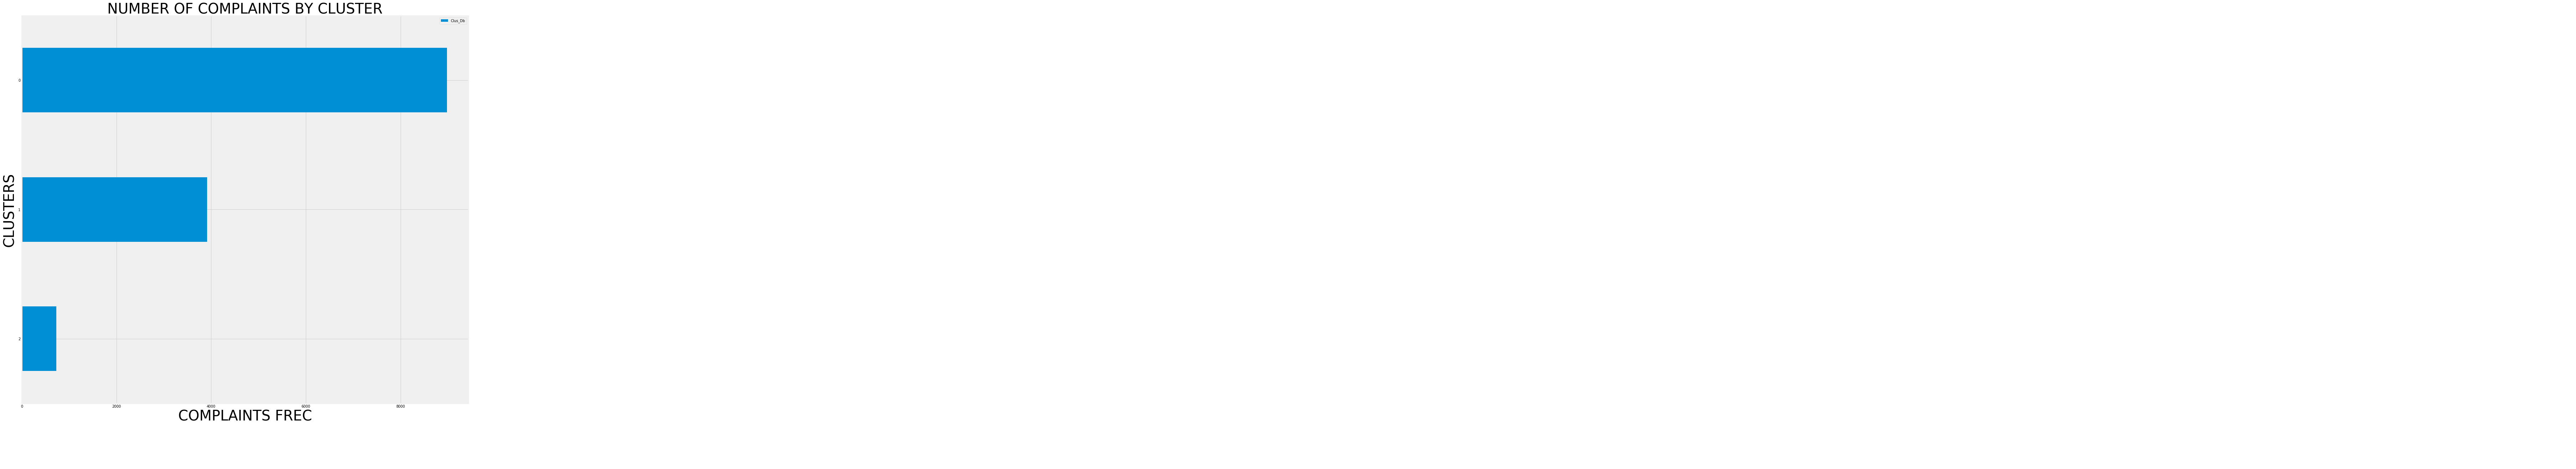

In [30]:
# Graphic visualization of complaint distribution per cluster

mpl.style.use("fivethirtyeight") #("ggplot")
% matplotlib inline

Z09=Z07[Z07['Clus_Db'] >-1]
Z088=pd.DataFrame(Z09["Clus_Db"].value_counts())
Z088.sort_values(by="Clus_Db",ascending=True).plot(kind="barh",figsize=(20,20))  
plt.xlabel('COMPLAINTS FREC', size=40)
plt.ylabel('CLUSTERS', size=40)
plt.title("NUMBER OF COMPLAINTS BY CLUSTER", size=40)
plt.annotate("TOP CLUSTER",
             xy=(7000,3),
             va="bottom",
             ha="left",
             size=40
            )

plt.show()

# This graph shows how clusters 0 and 1 concentrate the largest number of complaints  

In [31]:
# Preparing summary frame

Z08['part%']=100*(Z08.total_complaints/Z08.total_complaints.sum())
Z08.shape

(4, 3)

In [32]:
# COMPUTING SUMMARY TABLE

# Z07 = sample01[['Clus_Db', 'unique_key', 'latitude','longitude']]
Z08_minlat=Z07[['Clus_Db', 'latitude']].groupby(["Clus_Db"],as_index=False).min().sort_values(by="Clus_Db",ascending=True)
h_minlat=['Clus_Db', 'min_lat']
Z08_minlat.columns=h_minlat

Z08_maxlat=Z07[['Clus_Db', 'latitude']].groupby(["Clus_Db"],as_index=False).max().sort_values(by="Clus_Db",ascending=True)
h_maxlat=['Clus_Db', 'max_lat']
Z08_maxlat.columns=h_maxlat

Z08_minlong=Z07[['Clus_Db', 'longitude']].groupby(["Clus_Db"],as_index=False).min().sort_values(by="Clus_Db",ascending=True)
h_minlong=['Clus_Db', 'min_long']
Z08_minlong.columns=h_minlong

Z08_maxlong=Z07[['Clus_Db', 'longitude']].groupby(["Clus_Db"],as_index=False).max().sort_values(by="Clus_Db",ascending=True)
h_maxlong=['Clus_Db', 'max_long']
Z08_maxlong.columns=h_maxlong

Z08["minlat"]=Z08_minlat["min_lat"]    #Z10["latitude"]
Z08["maxlat"]=Z08_maxlat["max_lat"]
Z08["minlong"]=Z08_minlong["min_long"]
Z08["maxlong"]=Z08_maxlong["max_long"]
Z08["central_lat"]=(Z08.minlat+Z08.maxlat)/2
Z08["central_long"]=(Z08.minlong+Z08.maxlong)/2
Z08["KM_radius"]=111*(Z08.maxlong-Z08.central_long)
Z08

# This frame shows than: 
#    a) 31,8% of complaints were clasified as outlier by DBSCAN
#    b) 68,2% of complaints were clasified as clusters "0", "1", and "2", but mainly in clusters "0" and "1" (64,47%) 
#    c) Besides percentages this frame shows:
#       c.1) The the central coordinates of each cluster (lantitude and logitude)
#       c.2) The aproximated radius in kilometers of each cluster
#       c.3) The comparison of the radius in kilometers of each cluster vs the radius in kilometers of outliers.
#       c.4) The comparison explained in topic c.3) Shows how for example, the radius in kilometers of outliers is 30,4 Km, 
#            whereas cluster "0" is only 6,9 Km, and cluster "1" is only 4,1 Km


,Clus_Db,total_complaints,part%,minlat,maxlat,minlong,maxlong,central_lat,central_long,KM_radius
0,-1,6375,31.875,40.510277,40.909982,-74.249022,-73.701152,40.710129,-73.975087,30.406767
1,0,8981,44.905,40.769955,40.903427,-73.970748,-73.846132,40.836691,-73.908440,6.916183
2,1,3912,19.560,40.610669,40.713100,-73.979648,-73.904949,40.661885,-73.942298,4.145779
3,2,732,3.660,40.711306,40.750091,-74.005203,-73.978161,40.730699,-73.991682,1.500805


In [33]:
# Extrapolating to 2018s full data

CLUS00_2018=DFQ2[DFQ2["latitude"]>=Z08.iloc[1,3]]
CLUS00_2018=CLUS00_2018[CLUS00_2018["latitude"]<=Z08.iloc[1,4]]
CLUS00_2018=CLUS00_2018[CLUS00_2018["longitude"]>=Z08.iloc[1,5]]
CLUS00_2018=CLUS00_2018[CLUS00_2018["longitude"]<=Z08.iloc[1,6]]

print("The 2018s total complaints of HEAT/HOT WATER were ", DFQ2.shape[0]," complaints")
print("The 2018s total complaints of HEAT/HOT WATER in cluster -0- were ", CLUS00_2018.shape[0]," complaints")
print("It means that the ",int(100*(CLUS00_2018.shape[0]/DFQ2.shape[0])),"% of HEAT/HOT WATER occurred in cluster -0-")
print("(similar than random sample)")

The 2018s total complaints of HEAT/HOT WATER were  216273  complaints
The 2018s total complaints of HEAT/HOT WATER in cluster -0- were  101077  complaints
It means that the  46 % of HEAT/HOT WATER occurred in cluster -0-
(similar than random sample)


In [34]:
# Analysing of top cluster (cluster -0-) on 2018s full data

CLUS00_2018.describe(include="all")

# This cluster reduces the focus area to:
# from 183 to 47 "incident_zip" contiguous 
# from 3835 to 1229 "street_name" contiguous
# from 35693 to 12643 "incident address" contiguous
# Lets see the distribution by borough

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,borough,latitude,longitude,closed_date,location_type,status
count,101077,1.010770e+05,101077,101077.0,101077,101077,101077,101077,101077,101077.000000,101077.000000,100598,101077,101077
unique,98932,NaN,1,47.0,12643,1229,1,6,4,NaN,NaN,23159,1,2
top,2018-11-10 10:25:04,NaN,HEAT/HOT WATER,10458.0,1425 DR M L KING JR BOULEVARD,GRAND CONCOURSE,ADDRESS,BRONX,BRONX,NaN,NaN,2018-12-06 17:53:40,RESIDENTIAL BUILDING,Closed
freq,6,NaN,101077,6406.0,1015,3712,101077,66361,66361,NaN,NaN,145,101077,100598
first,2018-01-01 00:00:09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-01-01 02:05:57,NaN,NaN
last,2018-12-30 23:56:32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-08 18:38:07,NaN,NaN
mean,NaN,3.948810e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.840947,-73.909815,NaN,NaN,NaN
std,NaN,1.226472e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026269,0.029404,NaN,NaN,NaN
min,NaN,3.806665e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.769955,-73.970748,NaN,NaN,NaN
25%,NaN,3.832849e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.823863,-73.935407,NaN,NaN,NaN


In [35]:
CLUS00_borough=CLUS00_2018[['borough', 'unique_key']].groupby(["borough"],as_index=False).count() #.sort_values(by="borough",ascending=True)
CLUS00_borough['part%']=100*(CLUS00_borough.unique_key/CLUS00_borough.unique_key.sum())
CLUS00_borough

# The 99% of the Cluster -0- complaints are located in theboroughs BRONX (65.65%) and MANHATTAN (33.38%) 


,borough,unique_key,part%
0,BRONX,66361,65.653907
1,MANHATTAN,33737,33.377524
2,QUEENS,978,0.967579
3,Unspecified,1,0.000989


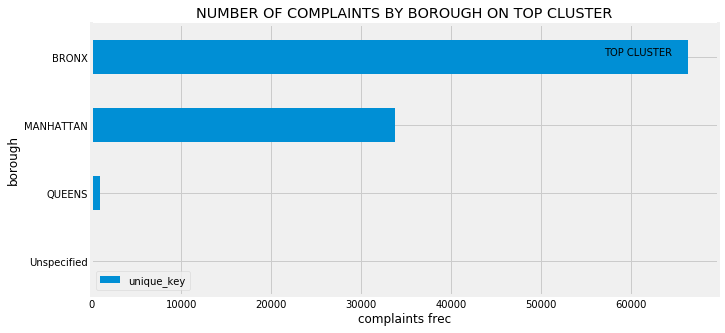

In [36]:
W01=CLUS00_borough[["borough","unique_key"]]
W01.set_index("borough",inplace=True)
W01.sort_values(by="unique_key",ascending=True).plot(kind="barh",figsize=(10,5))
plt.xlabel('complaints frec') #, size=40)
plt.ylabel('borough') #, size=40)
plt.title("NUMBER OF COMPLAINTS BY BOROUGH ON TOP CLUSTER") #, size=40)
plt.annotate("TOP CLUSTER",
             xy=(57000,3),
             va="bottom",
             ha="left"
             
            )

plt.show()

In [37]:
# 6. CONCLUSIONS

# SHOULD THE DHPDNYC FOCUS ON ANY PARTICULAR SET OF BOROUGHS, ZIP CODES, OR STREET 
# (WHERE THE COMPLAINTS ARE SEVERE) FOR THE SPECIFIC TYPE OF COMPLAINTS Y

# ANSWER:
# Yes, the DHPDNYC should focus on a specific area of NYC to improve their response capacity.
# They should focus in the area defined for the cluster -0- mainly. Their limit coords are
# upper-left 40.903427, -73.970748 
# lower right 40.769955, -73.846132
# This cluster includes aprox the 44.9% of Heat/Hot Water complaints of NYC
# The 99% complaints in this cluster are located in the boroughs: BRONX (65.65%) and MANHATTAN (33.38%). 